# Ciência de Dados - Trabalho Prático

## Alexandre Rosseto Lemos
### Matrícula: 2021231580
### email: alexandrerossetolemos@gmail.com
### PPGI (Mestrado)

# Objetivo

Utilizar aprendizado não supervisionado (neste caso, agrupamento) para investigar se há relação entre a descrição de um livro e o gênero literário a que pertence.

De forma mais específica, agrupar os livros de acordo suas descrições e, após isso, verificar se os livros pertencentes ao mesmo grupo possuem o mesmo gênero ou se as distribuições de gêneros de grupos diferentes são diferentes.

# Inicialização

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.metrics import accuracy_score

## Funções

### pre_processamento

In [2]:
def pre_processamento(text):
    '''
    Info:
        Funcao que realiza a normalizacao dos dados (textos)
    ----------
    Input:
        text: Texto a ser normalizado (type: string)
    ----------
    Output
        tokens: Texto apos passar pelos processos de normalizacao
    '''
    # Transformando letras maiusculas em minusculas e removendo pontuacao
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # Tokenizando o texto
    tokens = word_tokenize(text)
    
    # Obtendo as stop words e gerando o modelo para aplicar lematizacao
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    # Aplicando lematizacao e removendo stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return tokens

### analise_cluster

In [3]:
def analise_cluster(df, genero):
    '''
    Info:
        Funcao que filtra os dados por genero e gera um grafico com a quantidade de amostras
        de cada cluster que pertencem ao genero analisado.
    ----------
    Input:
        df: Conjunto de dados (type: pandas DataFrame)
        genero: Genero analisado (type: string)
    ----------
    Output:
        cl_res: Dicionario com os dois maiores clusters e a quantidade de amostras em cada um deles.
    '''
    # Obtendo os dados apenas do cluster desejado
    df_cl = df[df['genero'] == genero]
    
    # Gerando o grafico
    fig, ax = plt.subplots(figsize = [10,5])
    ax = sns.countplot(data = df_cl, x = 'cluster',
                      order = [0, 1, 2, 3, 4, 5, 6, 7])
    
    # Definindo titulo
    ax.set_title(genero)
    
    # Retornando os dois clusters mais comuns
    top_cluster_qtd = df_cl['cluster'].value_counts().iloc[0]
    top_cluster = df_cl['cluster'].value_counts().index[0]
    
    seg_cluster_qtd = df_cl['cluster'].value_counts().iloc[1]
    seg_cluster = df_cl['cluster'].value_counts().index[1]
    
    
    cl_res = {'Genero': genero, 
              'Maior cluster': ({'Cluster': top_cluster, 'Quantidade': top_cluster_qtd}), 
              'Segundo maior cluster': ({'Cluster': seg_cluster, 'Quantidade': seg_cluster_qtd})}
    
    return cl_res

### acc_genero

In [4]:
def acc_genero(df, nome_modelo):
    '''
    Info:
        Funcao que calcula a acuracia de um modelo para todos os generos separadamente.
    ----------
    Input:
        df: Conjunto de dados analisado (type: pandas DataFrame)
        nome_modelo: Nome do modelo analisado (type: string)
    ----------
    Output:
        df_gen_acc: Dataframe com a acuracia calculada para cada genero
    '''
    # Lista de generos
    genero_list = ['poetry', 'romance', 'children', 'comics_graphic', 
                   'fantasy_paranormal','history_biography', 'mystery_thriller_crime', 
                   'young_adult']
    
    dict_kmeans_svd_res = {}
    for genero in genero_list:
        # Obtendo apenas os dados do genero
        df_gen = df[df['genero'] == genero]
        
        # Calculando as acuracias
        acc = accuracy_score(df_gen['encoded_genre'], df_gen['cluster'])

        # Salvando em um dicionario
        dict_kmeans_svd_res[genero] = acc
    
    # Criando o dataframe
    df_gen_acc = pd.DataFrame(data = dict_kmeans_svd_res, index = [nome_modelo])

    return df_gen_acc

# Carregando os dados

Uma análise prévia foi feita para descobrir quantas amostras existem para cada dataset

- Romance:     335449 amostras
- Poetry:      36514 amostras
- Children:    124082 amostras
- Comics:      89411 amostras
- Fantasy:     258585 amostras
- Biography:   302935 amostras
- Mysterey:    219235 amostras
- Young adult: 93398 amostras

In [5]:
# Lista com os datasets a serem lidos
datasets = ['goodreads_books_romance.json', 
            'goodreads_books_poetry.json', 'goodreads_books_children.json',
            'goodreads_books_comics_graphic.json', 'goodreads_books_fantasy_paranormal.json',
            'goodreads_books_history_biography.json', 'goodreads_books_mystery_thriller_crime.json',
            'goodreads_books_young_adult.json'
           ]

# Lista com as colunas necessarias
cols_used = ['book_id', 'language_code', 'description']

df = pd.DataFrame()
for dataset in datasets:
    
    # Lendo os dados
    df_original = pd.read_json(dataset, lines = True)
    
    # Utilizando apenas as colunas necessarias
    df_original = df_original[cols_used]
    
    # Selecionando apenas registros onde language_code = en, eng, en-GB, en-US ou en-CA
    df_original = df_original[(df_original['language_code'] == 'en') | (df_original['language_code'] == 'eng')|  
                   (df_original['language_code'] == 'en-GB') | (df_original['language_code'] == 'en-US') | 
                   (df_original['language_code'] == 'en-CA')]
    
    # Existem amostras onde o campo description está vazio, essas amostras serao removidas
    df_original = df_original[df_original['description'] != '']
    
    # Selecionando aleatoriamente 1000 amostras do conjunto de dados
    df_sample = df_original.sample(n = 1000, random_state = 0)
    
    # Removendo da memoria o dataset original
    del df_original
      
    # Obtendo e salvando o genero do livro
    genero = dataset.split('_books_')[1].split('.json')[0]
    df_sample['genero'] = genero

    # Concatenando os dados
    df = pd.concat([df, df_sample])
    
    # Removendo da memoria o dataset amostrado
    del df_sample
    
# Reorganizando aleatoriamente os dados
df = df.sample(frac = 1, random_state = 0)

In [6]:
print(f'Shape do dataframe concatenado: {df.shape}')

Shape do dataframe concatenado: (8000, 4)


# Pré-processamento

A primeira etapa de pré-processamento consiste em:

- Transformar letras maíusculas em minúsculas;
- Remover pontuação;
- Remover stop words;
- Tokenizar os textos;
- Aplicar lematização.

As bibliotecas scikit-learn e nltk serão utilizadas para realizar esses procedimentos.

In [7]:
# Inicializando o objeto CountVectorizer com as funcoes de pre processamento criadas
vect = CountVectorizer(tokenizer = pre_processamento)

# Fazendo a contagem da frequencia das palavras
word_count = vect.fit_transform(df['description'])

## Matriz TF-IDF

In [8]:
# Inicializando o objeto tf-idf vectorizer
transformer = TfidfTransformer()

# Utilizando a contagem das palavras do vetor de contagem para treinar o objeto TfidTransformer
tfidf = transformer.fit_transform(word_count)

print("Shape da matriz TF-IDF:", tfidf.shape)
print(tfidf.toarray())

Shape da matriz TF-IDF: (8000, 43551)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Clusterização com Redução de Dimensionalidade

Podemos ver que a matriz TF-IDF é muito extensa, possui muitas colunas (43551) e é uma matriz esparsa, onde existe uma grande quantidade de células com valor igual à 0 (zero). 

Para tentar diminuir essa alta dimensionalidade, e se tratando de uma matriz esparsa, será utilizado o algoritmo SVD Truncado. A biblioteca scikit-learn possui esse algoritmo e ele será utilizado na etapa a seguir.

Para definir a melhor quantidade de componentes a ser utilizado, serão gerados alguns gráficos que mostram quanto da variância está sendo explicada pela quantidade de variáveis.

## Aplicando Truncated SVD para reduzir a dimensionalidade

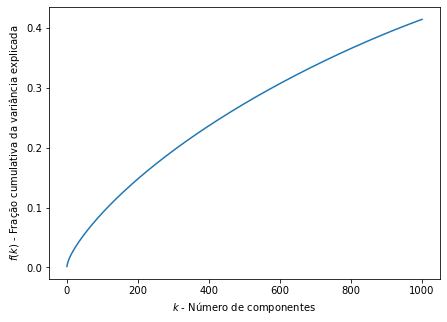

In [9]:
# Utilizando 1000 variaveis
svd_t = TruncatedSVD(n_components = 1000)
svd_t.fit(tfidf)

fig = plt.figure(figsize=(7, 5))  
plt.plot([i for i in range(1, svd_t.n_components + 1)], np.cumsum(svd_t.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');    

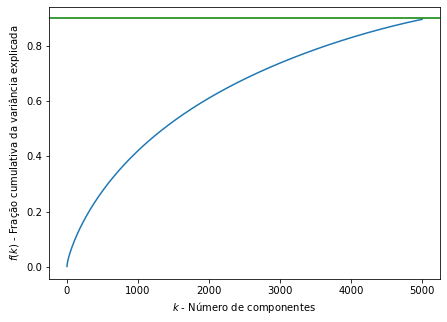

In [10]:
# Utilizando 5000 variaveis
svd_t = TruncatedSVD(n_components = 5000)
svd_t.fit(tfidf)

fig = plt.figure(figsize=(7, 5))  
plt.plot([i for i in range(1, svd_t.n_components + 1)], np.cumsum(svd_t.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada')

# Plotando uma linha onde as variaveis explicam 90% da variancia
plt.axhline(y = 0.9, color = 'g', linestyle='-');

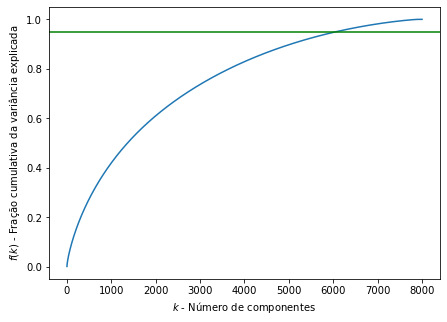

In [11]:
# Utilizando 8000 variaveis
svd_t = TruncatedSVD(n_components = 8000)
svd_t.fit(tfidf)

fig = plt.figure(figsize=(7, 5))  
plt.plot([i for i in range(1, svd_t.n_components + 1)], np.cumsum(svd_t.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada')  

# Plotando uma linha onde as variaveis explicam 95% da variancia
plt.axhline(y = 0.95, color = 'g', linestyle='-');

Para esse trabalho, serão utilizadas 6500 componentes pois, a partir dos gráficos, foi obseravdo que elas representam aproximadamente 95% da variância dos dados e representam menos de 15% do total de colunas do conjunto de dados original, significando uma diminuição considerável no número de variáveis.

In [12]:
# Utilizando 6500 variaveis
svd_t = TruncatedSVD(n_components = 6500, random_state = 0)

# Transformando os dados e salvando em um dataframe
data = pd.DataFrame(svd_t.fit_transform(tfidf))

data.head()

,0,1,2,3,4,5,6,7,8,9,...,6490,6491,6492,6493,6494,6495,6496,6497,6498,6499
0,0.101791,-0.004616,-0.028533,0.012799,-0.047208,-0.019753,-0.007271,-0.043673,0.008905,-0.010972,...,-0.004602,0.003560,0.000977,0.007565,-0.003434,0.001978,-0.004110,-0.009656,0.007282,0.010882
1,0.142694,0.131385,-0.066722,-0.019162,-0.013184,0.052643,-0.046612,-0.036839,0.008108,0.016782,...,0.001969,-0.010259,-0.007265,0.005040,0.008311,-0.004500,0.001684,-0.007138,0.008117,-0.007748
2,0.114991,0.003636,-0.034808,-0.027871,-0.028586,0.035880,-0.017834,0.018240,0.007015,0.019286,...,-0.008220,0.004955,-0.000904,0.001227,-0.000310,-0.004816,-0.002313,0.002232,-0.000600,-0.006457
3,0.191487,-0.018750,0.029765,0.050222,-0.015969,-0.004534,0.042560,-0.024726,-0.012375,0.017272,...,-0.007634,0.008533,0.000219,-0.007715,0.004826,-0.012385,0.000143,0.002249,0.001269,0.004917
4,0.143723,-0.056301,-0.000923,0.010401,-0.137245,0.001534,-0.005286,-0.006728,0.014643,0.062961,...,0.010341,-0.004822,0.004664,-0.003625,-0.001653,-0.001168,-0.005710,0.002161,-0.006198,-0.007053


Com o conjunto de dados reduzido, serão aplicadas três técnicas de agrupamento, sendo elas:
- K-Means
- Agrupamento Hierárquico
- Agrupamento Espectral


Como existem 8 gêneros literários diferentes, os algoritmos irão tentar agrupar os dados em 8 conjuntos diferentes.

In [13]:
# Lista de generos
genero_list = ['poetry', 
               'romance', 'children', 'comics_graphic', 'fantasy_paranormal',
               'history_biography', 'mystery_thriller_crime', 'young_adult'
              ]

## Utilizando K-Means

In [14]:
# Inicializando o modelo
kmeans_svd = KMeans(n_clusters = 8, random_state = 0)

# Treinando o modelo
kmeans_svd.fit(data)

df_kmeans_svd = pd.DataFrame(index = df.index)

# Obtendo os resultados do kmeans
df_kmeans_svd['cluster'] = kmeans_svd.labels_

# # Adicionando o genero literario ao dataframe
df_kmeans_svd['genero'] = df['genero'].values

df_kmeans_svd.head()

,cluster,genero
59612,0,comics_graphic
25671,1,poetry
168863,0,mystery_thriller_crime
274184,4,romance
73873,2,comics_graphic


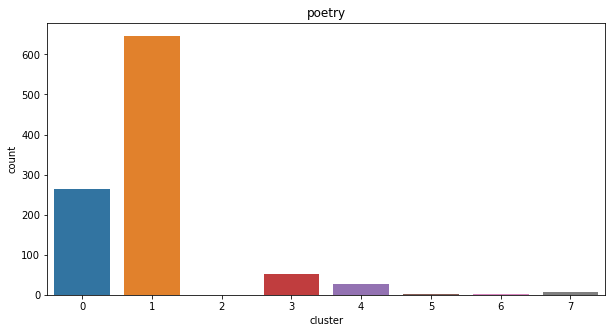

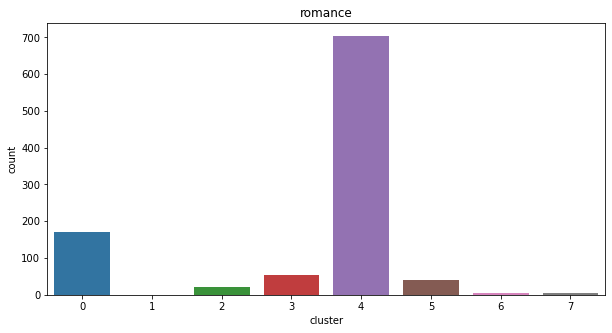

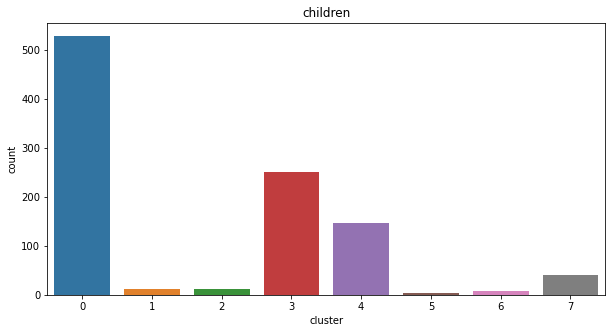

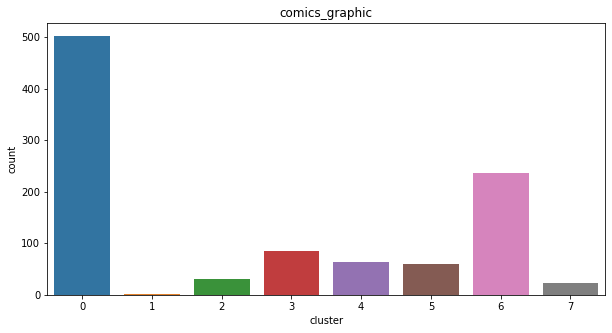

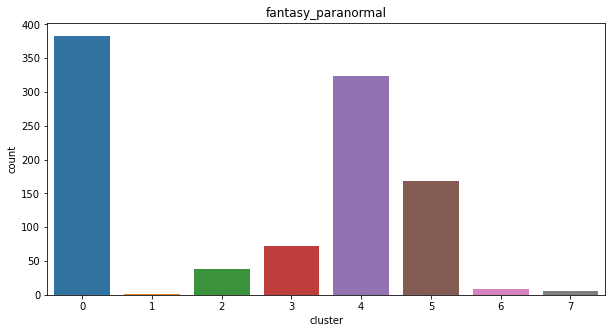

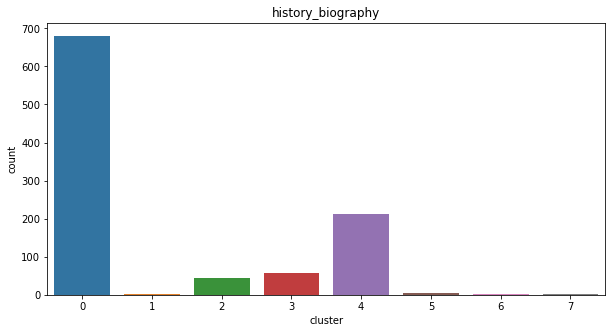

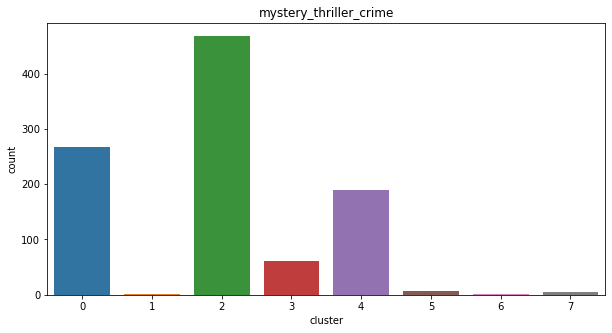

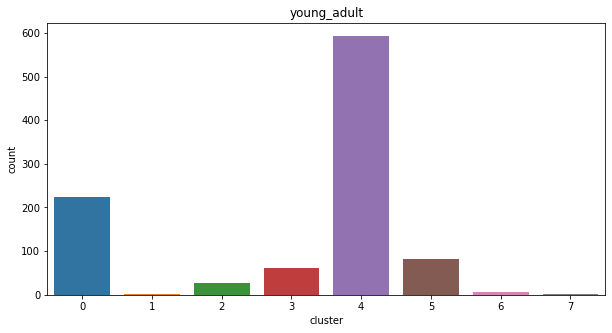

In [15]:
# Gerando os dados e graficos para cada genero
res_list = []
for genero in genero_list:
    res_list.append(analise_cluster(df_kmeans_svd, genero))

### Análise

Podemos ver que nenhum gênero possui apenas amostras pertecentes a um único cluster. Isso já era esperado visto que para isso ocorrer, as amostras desse gênero deveriam possuir informações muito exclusivas, portanto, palavras muito exclusivas.

Para avaliar quão bem o modelo conseguiu categorizar as amostras, é necessário determinar qual o gênero representado por cada cluster.

**Determinando qual gênero cada cluster representa**

O cluster com maior número de amostras (dentro de um gênero) será considerado o cluster que representa as amostras daquele gênero.

Caso um mesmo cluster seja o maior em dois gêneros (gênero 1 e gênero 2), ele irá representar o gênero  cuja quantidade de amostras pertencentes ao cluster for superior (gênero 1). O outro gênero (gênero 2) será representado pelo segundo maior cluster pertencente a ele.

Assim, temos que:

- Cluster 0 -> history_biography
- Cluster 1 -> poetry
- Cluster 2 -> mystery_thriller_crime
- Cluster 3 -> children
- Cluster 4 -> romance
- Cluster 5 -> fantasy_paranormal
- Cluster 6 -> comics_graphic
- Cluster 7 -> young_adult

Com essa definição, podemos calcular a performance do modelo utilizando como métrica a acurácia.

In [16]:
# Criando uma nova coluna com os generos codificados
df_kmeans_svd['encoded_genre'] = df_kmeans_svd['genero'].map({'history_biography': 0, 'poetry': 1, 'mystery_thriller_crime': 2, 'children': 3,
                         'romance': 4, 'fantasy_paranormal': 5, 'comics_graphic': 6, 'young_adult': 7}).values

# Calculando a acuracia
acc_score_kmeans_svd = accuracy_score(df_kmeans_svd['encoded_genre'], df_kmeans_svd['cluster'])
print('Acurácia K-Means: {:.3f}%'.format(acc_score_kmeans_svd * 100))

Acurácia K-Means: 39.425%


## Utilizando Agrupamento Hierárquico

In [17]:
# Criando o modelo
clustering_svd = AgglomerativeClustering(n_clusters = 8)

# Treinando o modelo
clustering_svd.fit(data)

df_hier_svd = pd.DataFrame(index = df.index)

# Obtendo os resultados do kmeans
df_hier_svd['cluster'] = clustering_svd.labels_

# # Adicionando o genero literario ao dataframe
df_hier_svd['genero'] = df['genero'].values

df_hier_svd.head()

,cluster,genero
59612,2,comics_graphic
25671,1,poetry
168863,0,mystery_thriller_crime
274184,2,romance
73873,0,comics_graphic


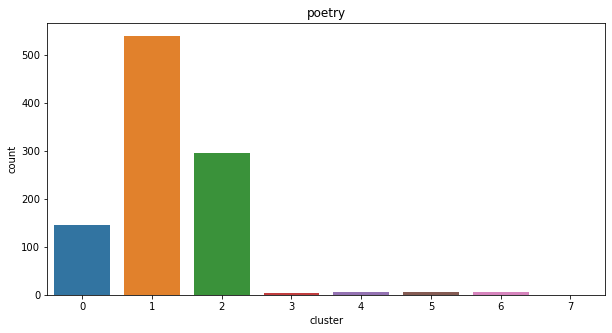

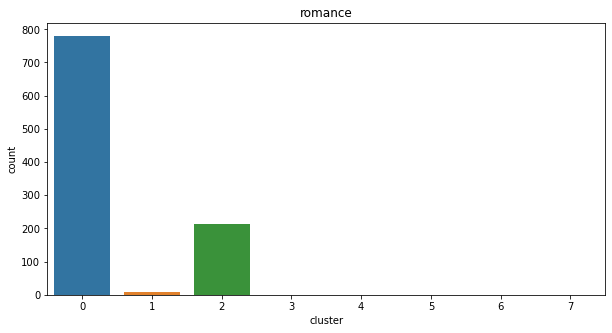

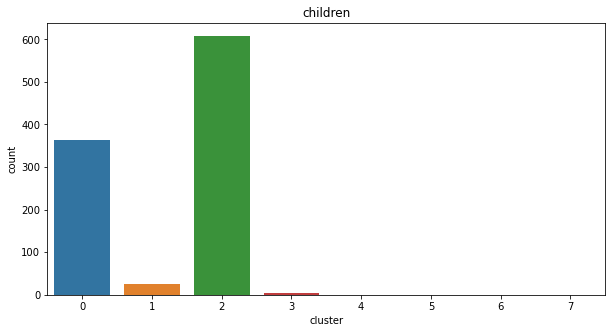

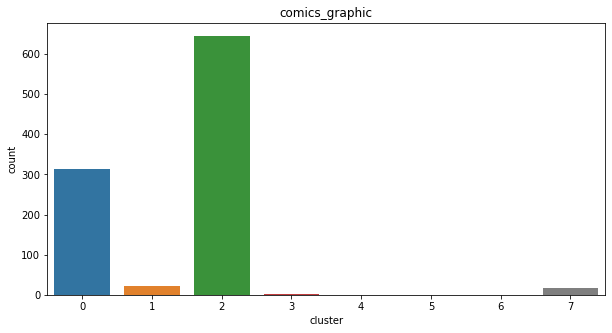

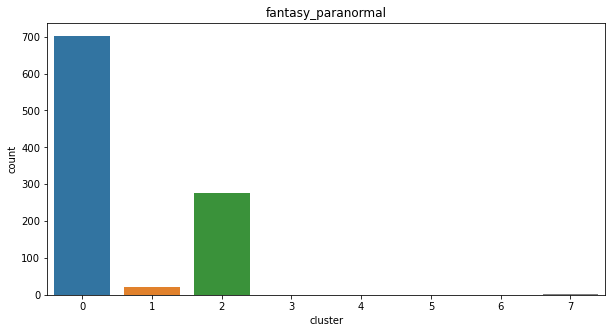

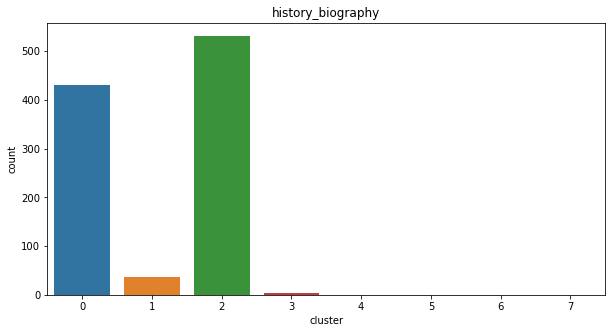

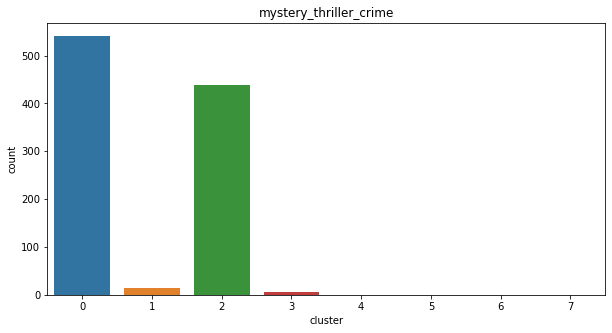

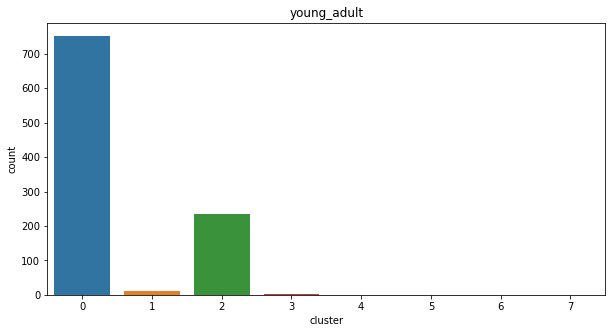

In [18]:
# Gerando os dados e graficos para cada genero
res_list = []
for genero in genero_list:
    res_list.append(analise_cluster(df_hier_svd, genero))

### Análise

Pode-se perceber que o agrupamento hierárquico não foi capaz de chegar a 8 grupos diferentes. Sendo assim, apenas 3 dos 8 gêneros serão relacionados a clusters, com o restante dos clusters sendo considerados como classificações erradas.

Assim:
- Cluster 0 -> romance
- Cluster 1 -> poetry
- Cluster 2 -> comics_graphic
- Cluster 3 -> impreciso
- Cluster 4 -> impreciso
- Cluster 5 -> impreciso
- Cluster 6 -> impreciso
- Cluster 7 -> impreciso

In [19]:
# Criando uma nova coluna com os generos codificados
df_hier_svd['encoded_genre'] = df_hier_svd['genero'].map({'romance': 0, 'poetry': 1, 'comics_graphic': 2, 'history_biography': 8,
                         'children': 8, 'mystery_thriller_crime': 8, 'fantasy_paranormal': 8, 'young_adult': 8}).values

# Calculando a acuracia
acc_score_hier_svd = accuracy_score(df_hier_svd['encoded_genre'], df_hier_svd['cluster'])
print('Acurácia Agrupamento Hierárquico: {:.3f}%'.format(acc_score_hier_svd * 100))

Acurácia Agrupamento Hierárquico: 24.562%


## Utilizando Agrupamento Espectral

In [20]:
# Criando o modelo
spec_clus_svd = SpectralClustering(n_clusters = 8, random_state = 0)

# Treinando o modelo
spec_clus_svd.fit(data)

df_spec_svd = pd.DataFrame(index = df.index)

# Obtendo os resultados do kmeans
df_spec_svd['cluster'] = spec_clus_svd.labels_

# # Adicionando o genero literario ao dataframe
df_spec_svd['genero'] = df['genero'].values

df_spec_svd.head()

,cluster,genero
59612,1,comics_graphic
25671,7,poetry
168863,3,mystery_thriller_crime
274184,5,romance
73873,1,comics_graphic


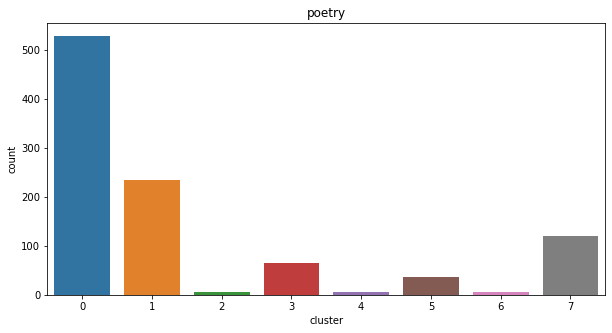

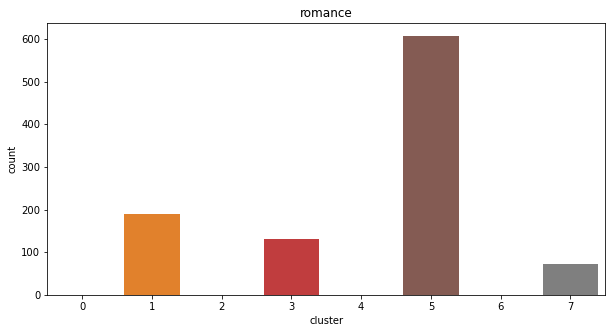

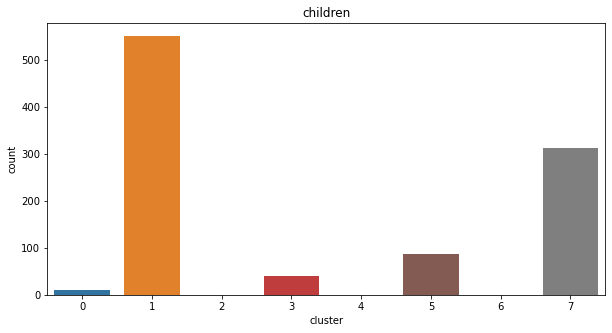

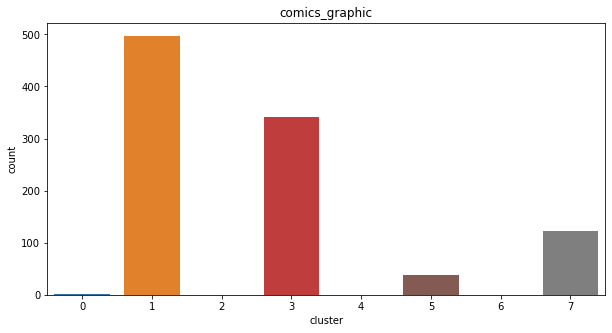

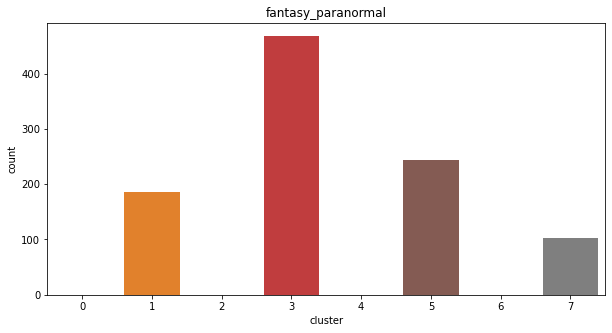

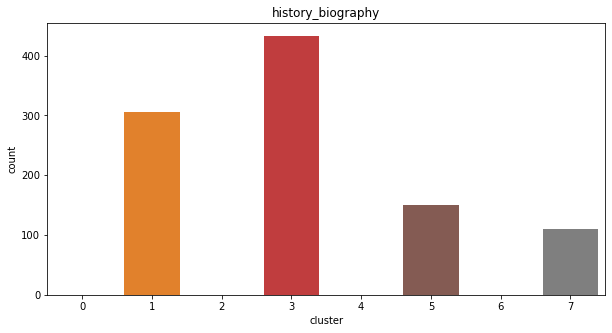

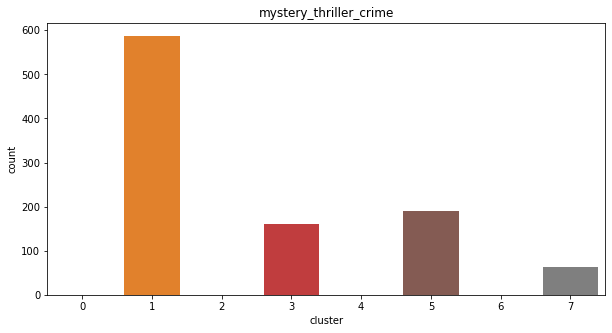

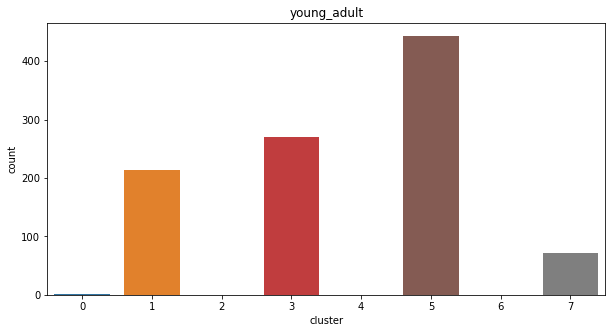

In [21]:
# Gerando os dados e graficos para cada genero
res_list = []
for genero in genero_list:
    res_list.append(analise_cluster(df_spec_svd, genero))

### Análise

Semelhante ao agrupamento hierárquico, não foi possível de chegar a 8 grupos diferentes. Sendo assim, apenas 5 dos 8 gêneros serão relacionados a clusters, com o restante dos clusters sendo considerados como classificações erradas.

Assim:
- Cluster 0 -> poetry
- Cluster 1 -> mystery_thriller_crime
- Cluster 2 -> impreciso
- Cluster 3 -> history_biography
- Cluster 4 -> impreciso
- Cluster 5 -> romance
- Cluster 6 -> impreciso
- Cluster 7 -> children

In [22]:
# Criando uma nova coluna com os generos codificados
df_spec_svd['encoded_genre'] = df_spec_svd['genero'].map({'poetry': 0, 'mystery_thriller_crime': 1, 'comics_graphic': 8, 'history_biography': 3,
                         'children': 7, 'romance': 5, 'fantasy_paranormal': 8, 'young_adult': 8}).values

# Calculando a acuracia
acc_score_spec_svd = accuracy_score(df_spec_svd['encoded_genre'], df_spec_svd['cluster'])
print('Acurácia Agrupamento Espectral: {:.3f}%'.format(acc_score_spec_svd * 100))

Acurácia Agrupamento Espectral: 30.862%


# Clusterização sem Redução de Dimensionalidade

Agora, o mesmo procedimento realizado anteriormente será refeito, porém dessa vez sem que os dados tenham sofrido redução de dimensionalidade. 

## Utilizando K-Means

In [23]:
# Inicializando o modelo
kmeans = KMeans(n_clusters = 8, random_state = 0)

# Treinando o modelo
kmeans.fit(tfidf)

df_kmeans = pd.DataFrame(index = df.index)

# Obtendo os resultados do kmeans
df_kmeans['cluster'] = kmeans.labels_

# # Adicionando o genero literario ao dataframe
df_kmeans['genero'] = df['genero'].values

df_kmeans.head()

,cluster,genero
59612,7,comics_graphic
25671,1,poetry
168863,2,mystery_thriller_crime
274184,4,romance
73873,2,comics_graphic


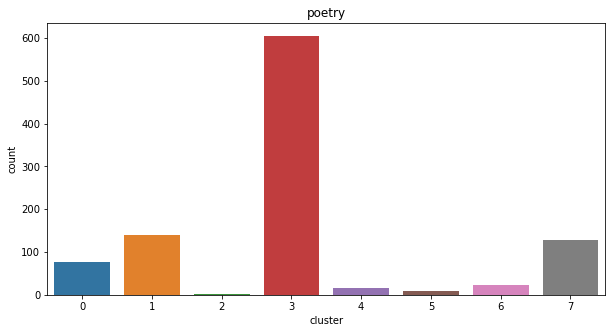

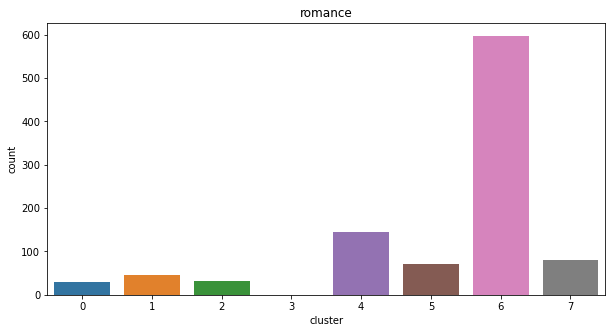

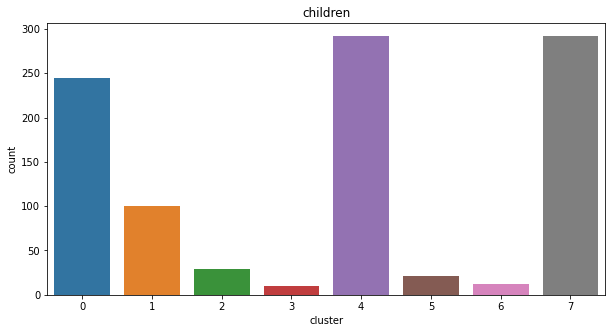

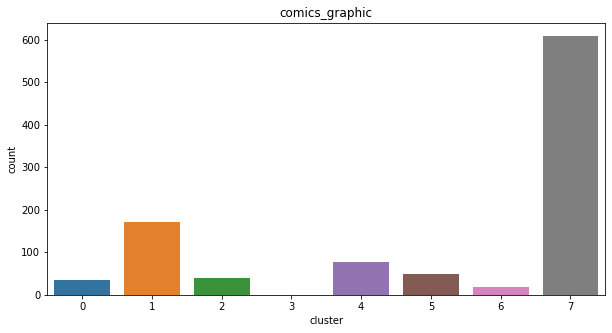

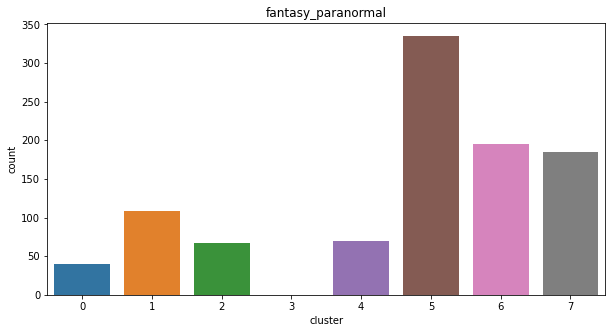

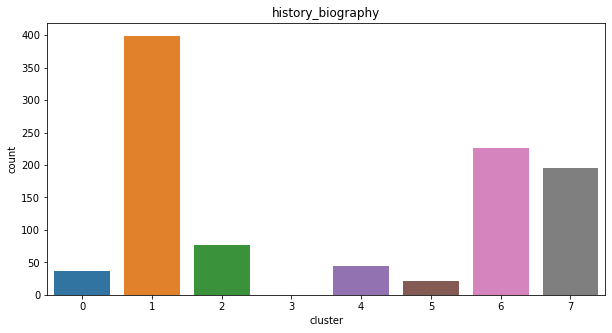

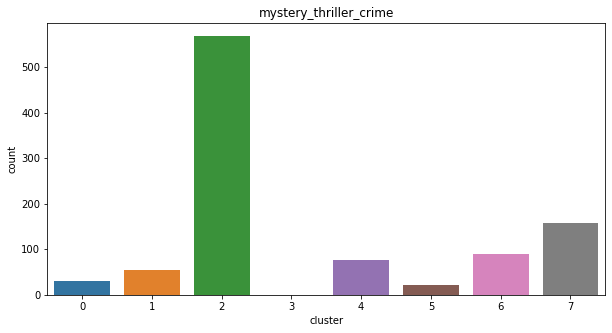

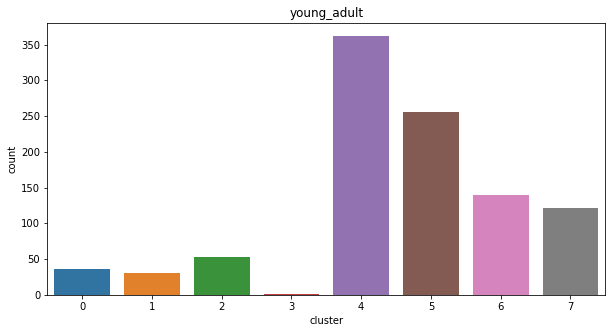

In [24]:
# Gerando os dados e graficos para cada genero
res_list = []
for genero in genero_list:
    res_list.append(analise_cluster(df_kmeans, genero))

### Análise

Aplicando a mesma metodologia que foi aplicada para os dados com redução de dimensionalidade, temos:

- Cluster 0 -> children
- Cluster 1 -> history_biography
- Cluster 2 -> mystery_thriller_crime
- Cluster 3 -> poetry
- Cluster 4 -> young_adult
- Cluster 5 -> fantasy_paranormal
- Cluster 6 -> romance
- Cluster 7 -> comics_graphic

In [25]:
# Criando uma nova coluna com os generos codificados
df_kmeans['encoded_genre'] = df_kmeans['genero'].map({'poetry': 3, 'mystery_thriller_crime': 2, 'comics_graphic': 7, 'history_biography': 1,
                         'children': 0, 'romance': 6, 'fantasy_paranormal': 5, 'young_adult': 4}).values

# Calculando a acuracia
acc_score_kmeans = accuracy_score(df_kmeans['encoded_genre'], df_kmeans['cluster'])
print('Acurácia K-Means: {:.3f}%'.format(acc_score_kmeans * 100))

Acurácia K-Means: 46.487%


## Utilizando Agrupamento Hierárquico

In [26]:
# Criando o modelo
clustering = AgglomerativeClustering(n_clusters = 8)

# Treinando o modelo
clustering.fit(tfidf.toarray())

df_hier = pd.DataFrame(index = df.index)

# Obtendo os resultados do kmeans
df_hier['cluster'] = clustering.labels_

# # Adicionando o genero literario ao dataframe
df_hier['genero'] = df['genero'].values

df_hier.head()

,cluster,genero
59612,0,comics_graphic
25671,1,poetry
168863,2,mystery_thriller_crime
274184,0,romance
73873,2,comics_graphic


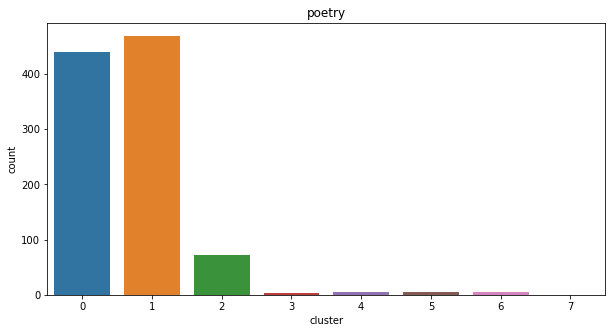

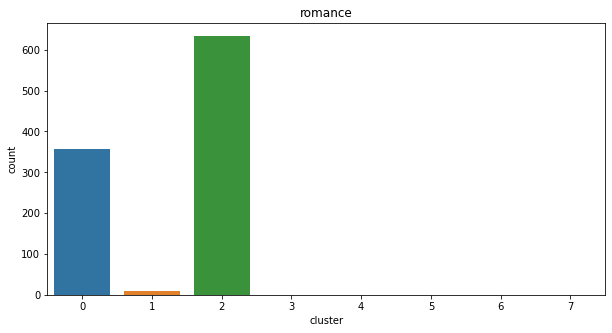

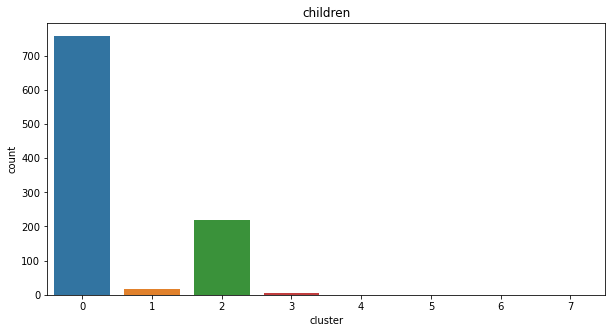

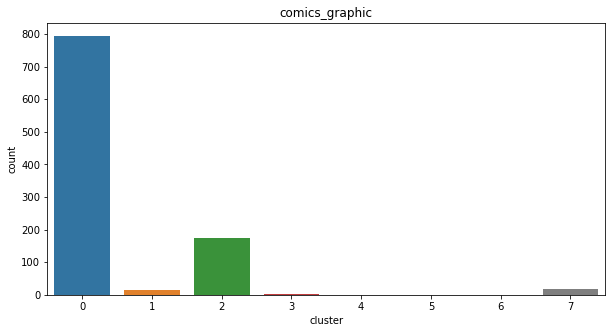

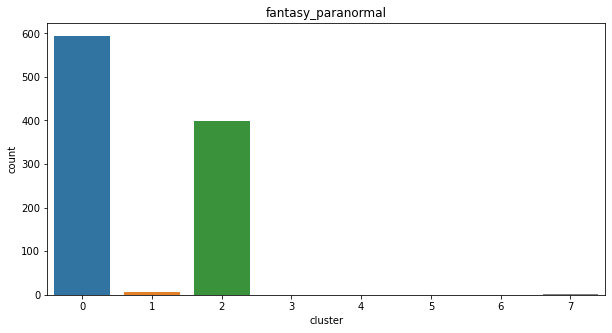

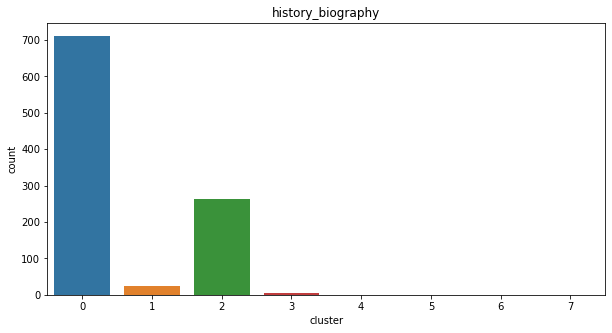

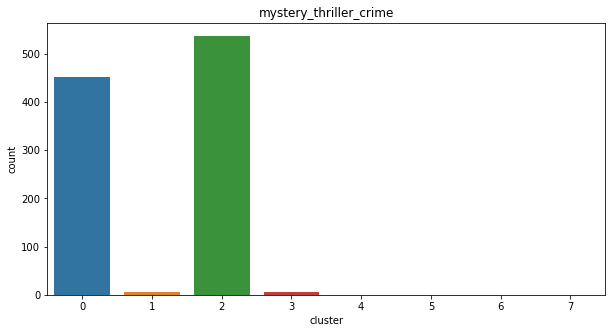

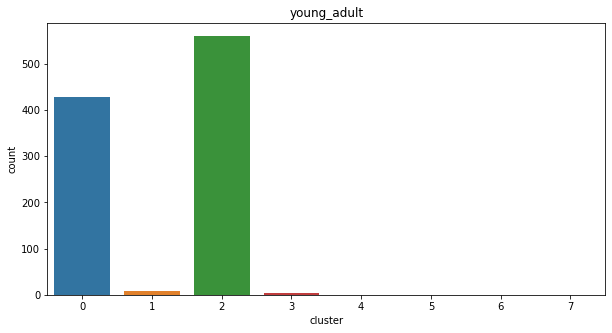

In [27]:
# Gerando os dados e graficos para cada genero
res_list = []
for genero in genero_list:
    res_list.append(analise_cluster(df_hier, genero))

### Análise

Semelhante ao que resultado obtido para os dados com redução de dimensionalidade, apenas 3 clusters possuem uma quantidade significativa de amostras.

Aplicando a mesma metodologia que foi aplicada para os dados com redução de dimensionalidade, temos:

- Cluster 0 -> comics_graphic
- Cluster 1 -> poetry
- Cluster 2 -> romance
- Cluster 3 -> impreciso
- Cluster 4 -> impreciso
- Cluster 5 -> impreciso
- Cluster 6 -> impreciso
- Cluster 7 -> impreciso

In [28]:
# Criando uma nova coluna com os generos codificados
df_hier['encoded_genre'] = df_hier['genero'].map({'poetry': 1, 'mystery_thriller_crime': 8, 'comics_graphic': 0, 'history_biography': 8,
                         'children': 8, 'romance': 2, 'fantasy_paranormal': 8, 'young_adult': 8}).values

# Calculando a acuracia
acc_score_hier = accuracy_score(df_hier['encoded_genre'], df_hier['cluster'])
print('Acurácia Agrupamento Hierárquico: {:.3f}%'.format(acc_score_hier * 100))

Acurácia Agrupamento Hierárquico: 23.712%


## Aplicando Agrupamento Espectral

In [29]:
# Criando o modelo
spec_clus = SpectralClustering(n_clusters = 8, random_state = 0)

# Treinando o modelo
spec_clus.fit(tfidf.toarray())

df_spec = pd.DataFrame(index = df.index)

# Obtendo os resultados do kmeans
df_spec['cluster'] = spec_clus.labels_

# # Adicionando o genero literario ao dataframe
df_spec['genero'] = df['genero'].values

df_spec.head()

,cluster,genero
59612,1,comics_graphic
25671,5,poetry
168863,0,mystery_thriller_crime
274184,6,romance
73873,1,comics_graphic


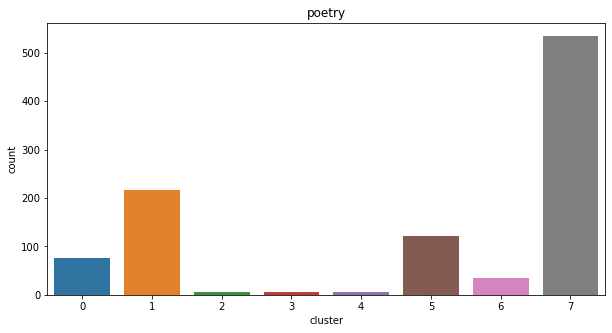

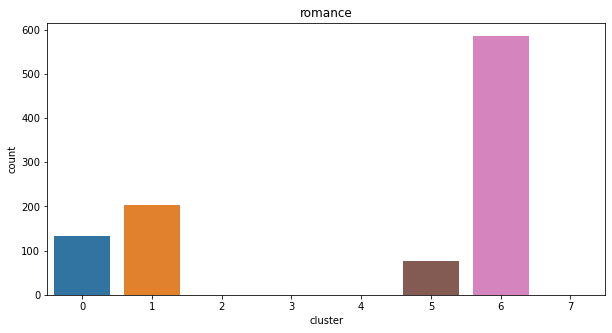

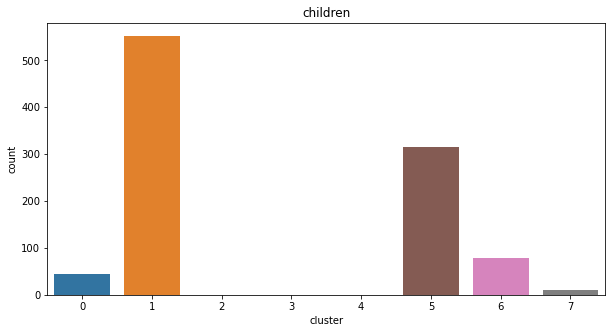

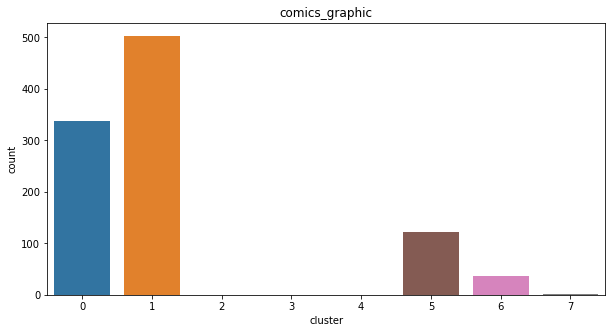

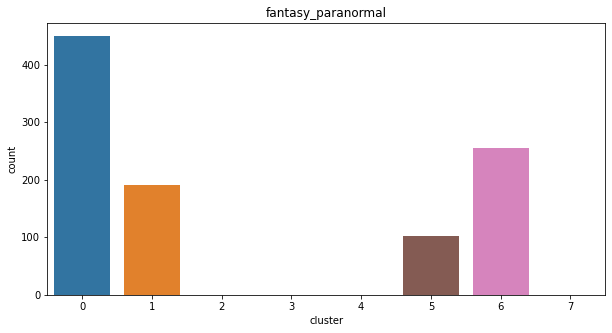

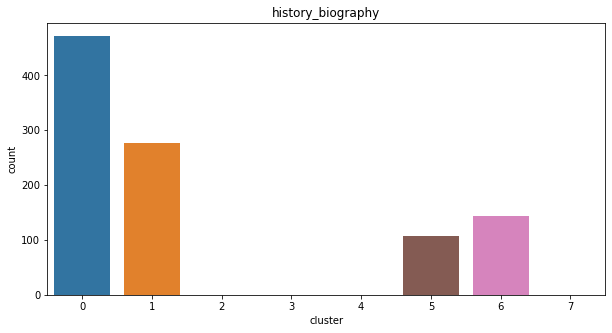

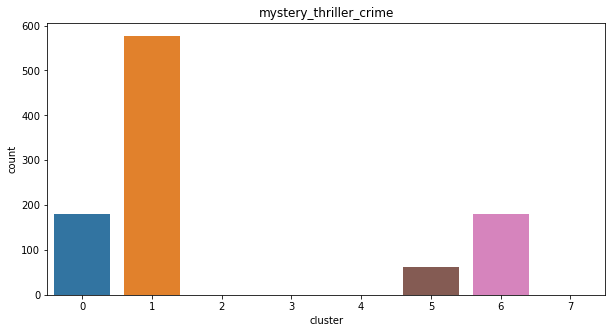

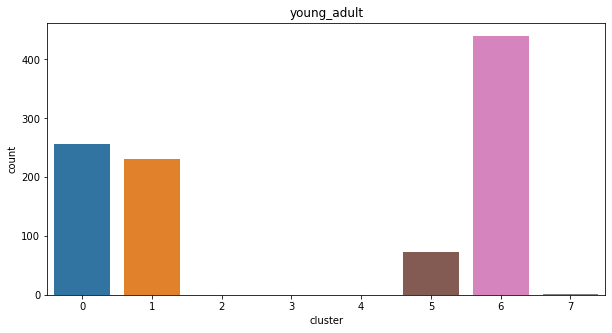

In [30]:
# Gerando os dados e graficos para cada genero
res_list = []
for genero in genero_list:
    res_list.append(analise_cluster(df_spec, genero))

### Análise

Semelhante ao que resultado obtido para os dados com redução de dimensionalidade, apenas 5 clusters possuem uma quantidade significativa de amostras.

Aplicando a mesma metodologia que foi aplicada para os dados com redução de dimensionalidade, temos:

- Cluster 0 -> fantasy_paranormal
- Cluster 1 -> mystery_thriller_crime
- Cluster 2 -> impreciso
- Cluster 3 -> impreciso
- Cluster 4 -> impreciso
- Cluster 5 -> children
- Cluster 6 -> romance
- Cluster 7 -> poetry

In [31]:
# Criando uma nova coluna com os generos codificados
df_spec['encoded_genre'] = df_spec['genero'].map({'poetry': 7, 'mystery_thriller_crime': 1, 'comics_graphic': 8, 'history_biography': 8,
                         'children': 5, 'romance': 6, 'fantasy_paranormal': 0, 'young_adult': 8}).values

# Calculando a acuracia
acc_score_spec = accuracy_score(df_spec['encoded_genre'], df_spec['cluster'])
print('Acurácia Agrupamento Espectral: {:.3f}%'.format(acc_score_spec * 100))

Acurácia Agrupamento Espectral: 30.788%


# Resultados

A seguir, todos os resultados obtidos serão resumidos em uma tabela para facilitar na comparação entre os diferentes métodos.

In [32]:
# Gerando uma tabela com os resultados
data_res = pd.DataFrame(data = {'Sem redução de dimensionalidade': [acc_score_kmeans, acc_score_hier, acc_score_spec], 
                                'Com redução de dimensionalidade': [acc_score_kmeans_svd, acc_score_hier_svd, acc_score_spec_svd]}, 
                        index = ['K-Means', 'Agrp. Hierárquico', 'Agrp. Espectral'])

data_res

,Sem redução de dimensionalidade,Com redução de dimensionalidade
K-Means,0.464875,0.394250
Agrp. Hierárquico,0.237125,0.245625
Agrp. Espectral,0.307875,0.308625


# Conclusão

Observando os resultados, podemos concluir que nenhum dos métodos propostos conseguiu agrupar os livros por gênero de forma efetiva. O melhor resultado obtido, teve uma acurácia de apenas 46,49% aproximadamente. Isso significa que, em geral, os modelos não foram capaz de detectar muita relação entre as descrições dos livros e os gêneros literários aos quais eles pertencem.

Conclui-se também que aplicar a redução de dimensionalidade, para esse conjunto de dados, não resultou na melhora expressiva dos resultados. Para o Agrupamento Hierárquico houve um aumento de 0,85% na acurácia e para o Agrupamento Espectral houve um aumento de 0,07% aproxidamante. No entano, para o K-Means, o conjunto de dados que não sofreu redução de dimensionalidade apresentou uma acurácia 7,23% maior, aproxidamente, quando comparado com o conjunto com menos variáveis.

# Análise por gênero

Agora será feita uma análise por gênero literário para determinar qual a acurácia dos modelos para cada gênero.

In [33]:
# Lista dos modelos
lista_modelos = [(df_kmeans_svd, 'K-Means com TSVD'), (df_hier_svd, 'Agr. Hierarquico com TSVD'), 
                 (df_spec_svd, 'Agr. Espectral com TSVD'), (df_kmeans, 'K-Means sem TSVD'),
                 (df_hier, 'Agr. Hierarquico sem TSVD'), (df_spec, 'Agr. Espectral sem TSVD')]

df_resultados = pd.DataFrame()
for modelo, nome in lista_modelos:
    data_modelos = acc_genero(modelo, nome)
    df_resultados = pd.concat([df_resultados, data_modelos], axis = 0)
    
df_resultados

,poetry,romance,children,comics_graphic,fantasy_paranormal,history_biography,mystery_thriller_crime,young_adult
K-Means com TSVD,0.646,0.704,0.250,0.236,0.168,0.680,0.468,0.002
Agr. Hierarquico com TSVD,0.540,0.780,0.000,0.645,0.000,0.000,0.000,0.000
Agr. Espectral com TSVD,0.529,0.607,0.313,0.000,0.000,0.433,0.587,0.000
K-Means sem TSVD,0.605,0.597,0.244,0.609,0.335,0.399,0.568,0.362
Agr. Hierarquico sem TSVD,0.469,0.634,0.000,0.794,0.000,0.000,0.000,0.000
Agr. Espectral sem TSVD,0.535,0.586,0.315,0.000,0.450,0.000,0.577,0.000


# Análise

Pode-se perceber que quando os modelos são analisados individualmente por gênero, os resultados são bem diferentes dos obtidos anteriormente. Aqui é possível perceber que para alguns gêneros, os modelos conseguem resultados significativos, como por exemplo o Agrupamento Hierárquico sem redução de dimensionalidade, que obteve 79,40% de acurácia na classificação dos textos do gênero comics_graphic.

Pode-se perceber também que para essa análise, em geral, os resultados foram consideravelmente diferentes entre os conjuntos de dados com diminuição de dimensionalidade e os sem redução de dimensionalidade. As maiores diferenças foram para os gêneros romance (Agr. Hierarquico: diferença de 14,6%), comics_graphic (K-Means: diferença de 37,3%), history_biography (K-Means: diferença de 28,1%) e young_adult (K-Means: diferença de 36%).

# Conclusão

Os modelos obtiveram uma performance melhor quando os gêneros foram analisados individualmente se comparados com os resultados obtidos considerando todos os gêneros juntos. Isso pode ser justificado pois, para alguns gêneros, os modelos tiveram uma performance muito ruim (children, fantasy_paranormal e young_adult), o que acabou reduziondo a acurácia total, mescom com alguns gêneros obtendo uma acurácia relativamente boa, acima de 75% (romance, comics_graph).

Quanto à redução de dimensionalidade não foi possível chegar a nenhuma conclusão unânime. Para algumas análises ela melhorou o resultado obtido, enquanto que para outras ela diminui a acurácia. 